<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# <div align="center"><font>  </font></div>
# <div align="center"><font> COSC 2793 Computational Machine Learning </font></div>
## <div align="center"> <font> Assignment 2: Machine Learning Project </font></div>
## <div align="center"> <font> S3930776 Afrah Hassan A Alshaikh Ali & S3569266 Chang Su </font></div>
---

In [61]:
#Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score




Workflow
We need to follow the below 4 steps to build our traffic sign classification model:

Dataset exploration
CNN model building
Model training and validation
Model testing
https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/


# **1. Load Data into DataFrame**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [54]:
# Step 1: Load Data into DataFrame
def load_data_into_dataframe(data_dir):
    """
    Function to load data from a directory into a Pandas DataFrame.

    Args:
    - data_dir (str): Path to the directory containing the data.

    Returns:
    - df (DataFrame): Pandas DataFrame containing the loaded data.
    """
    data = []

    # Iterate through shape folders
    for shape_folder in os.listdir(data_dir):
        shape_folder_path = os.path.join(data_dir, shape_folder)

        # Skip non-directory files
        if not os.path.isdir(shape_folder_path):
            continue

        # Iterate through sign type folders
        for sign_type_folder in os.listdir(shape_folder_path):
            sign_type_folder_path = os.path.join(shape_folder_path, sign_type_folder)

            # Skip non-directory files
            if not os.path.isdir(sign_type_folder_path):
                continue

            # Iterate through image files
            for image_file in os.listdir(sign_type_folder_path):
                image_path = os.path.join(sign_type_folder_path, image_file)

                # Append image path, shape label, and sign label to the data list
                data.append((image_path, shape_folder, sign_type_folder))

    # Create DataFrame from the collected data
    df = pd.DataFrame(data, columns=['image_path', 'shape_label', 'sign_label'])
    return df

# Example usage
data_dir = "/content/drive/My Drive/Assignment2/trafficsigns_dataset"
df = load_data_into_dataframe(data_dir)
print(df.head())  # Print the first few rows of the DataFrame


                                          image_path shape_label sign_label
0  /content/drive/My Drive/Assignment2/trafficsig...      square   crossing
1  /content/drive/My Drive/Assignment2/trafficsig...      square   crossing
2  /content/drive/My Drive/Assignment2/trafficsig...      square   crossing
3  /content/drive/My Drive/Assignment2/trafficsig...      square   crossing
4  /content/drive/My Drive/Assignment2/trafficsig...      square   crossing


This function load_data_into_dataframe loads image data from a directory into a DataFrame. It iterates through the directory structure to find image files and assigns them labels based on the folder structure. Then, it creates a DataFrame with columns for image paths, shape labels, and sign labels. Finally, it returns the DataFrame containing the loaded data.

In [76]:
# Check the size of the DataFrame
print("DataFrame Size:")
print(df.shape)

# Display basic information about the DataFrame
print("\nDataFrame Information:")
print(df.info())

# Display descriptive statistics of the DataFrame
print("\nDataFrame Descriptive Statistics:")
print(df.describe())

DataFrame Size:
(3700, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3700 non-null   object
 1   shape_label  3700 non-null   object
 2   sign_label   3700 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path shape_label  \
count                                                3700        3700   
unique                                               3700           5   
top     /content/drive/My Drive/Assignment2/trafficsig...       round   
freq                                                    1        1760   

       sign_label  
count        3700  
unique         16  
top       warning  
freq          696  


In [77]:
# Number of data points
num_data_points = len(df)
print("Number of Data Points:", num_data_points)

# Count of unique shape types
num_unique_shapes = df['shape_label'].nunique()
print("Number of Unique Shape Types:", num_unique_shapes)
# Count of unique image types
num_unique_image_types = df['sign_label'].nunique()
print("Number of Unique Image Types:", num_unique_image_types)


Number of Data Points: 3700
Number of Unique Shape Types: 5
Number of Unique Image Types: 16


In [78]:
# Number of each shape type
shape_counts = df['shape_label'].value_counts()
print("Number of Each Shape Type:")
print(shape_counts)

# Number of each image type
image_counts = df['sign_label'].value_counts()
print("\nNumber of Each Image Type:")
print(image_counts)

Number of Each Shape Type:
shape_label
round       1760
triangle     927
square       688
diamond      282
hex           43
Name: count, dtype: int64

Number of Each Image Type:
sign_label
warning             696
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


# **2. Split the Data**

In [55]:
# Step 2: Split Data for Each Sign Label
# Initialize lists to store data splits
train_data = []
val_data = []
test_data = []

# Group DataFrame by sign labels
sign_groups = df.groupby('sign_label')

# Split data for each sign label
for sign_label, group_df in sign_groups:
    # Split data into training and testing sets (80% training, 20% testing)
    train_group, test_group = train_test_split(group_df, test_size=0.2, random_state=42)
    # Further split training data into training and validation sets (80% training, 20% validation)
    train_group, val_group = train_test_split(train_group, test_size=0.2, random_state=42)
    # Append data splits to respective lists
    train_data.append(train_group)
    val_data.append(val_group)
    test_data.append(test_group)

# Concatenate data splits to create final DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
test_df = pd.concat(test_data)


This code will split the data into training, validation, and testing sets for each sign label, ensuring a balanced distribution of data across the splits.

# **3. Load and Preprocess Images**


In [56]:
# Step 3: Load and Preprocess Images for Training and Testing
def load_and_preprocess_images(df):
    images = []  # List to store preprocessed images
    labels = []  # List to store corresponding labels

    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Check if the file name is not ".DS_Store"
        if not row['image_path'].endswith('.DS_Store'):
            # Load the image using OpenCV (grayscale mode)
            image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)

            # Check if the image is loaded successfully
            if image is not None:
                # Resize the image to 28x28 pixels
                image = cv2.resize(image, (28, 28))

                # Normalize pixel values to the range [0, 1] (float32)
                image = image.astype('float32') / 255.0

                # Add the preprocessed image to the list
                images.append(image)

                # Add the corresponding label to the list
                labels.append(row['shape_label'])
            else:
                # Print an error message if image loading fails
                print("Error: Unable to load image:", row['image_path'])
        else:
            # Skip ".DS_Store" files (common on macOS systems)
            print("Skipping .DS_Store file:", row['image_path'])

    # Convert lists to numpy arrays for efficient processing
    images = np.array(images)
    labels = np.array(labels)

    # Add channel dimension for Conv2D input (required by Keras)
    images = np.expand_dims(images, axis=-1)

    return images, labels

# Load and preprocess images for training, validation, and testing sets
train_images, train_labels = load_and_preprocess_images(train_df)
val_images, val_labels = load_and_preprocess_images(val_df)
test_images, test_labels = load_and_preprocess_images(test_df)


Skipping .DS_Store file: /content/drive/My Drive/Assignment2/trafficsigns_dataset/triangle/warning/.DS_Store


This function iterates over each row in the DataFrame, loads the corresponding image using OpenCV, resizes it to 28x28 pixels, normalizes the pixel values, and stores the preprocessed images and labels in lists. Finally, it converts the lists to numpy arrays and adds a channel dimension for compatibility with Conv2D layers in Keras.

# **4. Train the Baseline Model**


In this report, a Convolutional Neural Network (CNN) is employed as the baseline model for image classification tasks owing to its aptitude in handling visual data. CNNs are adept at automatically extracting relevant features from images through layers like convolutional and pooling layers, enabling them to discern intricate patterns, textures, and shapes. Their hierarchical learning approach facilitates the capturing of complex relationships within images, making them ideal for tasks like image classification. Additionally, CNNs have exhibited exceptional performance across various computer vision applications and are particularly robust to variations in input data, further solidifying their suitability as a baseline model for image classification endeavors.

In [57]:
# Step 4: Define and Compile the Model
# Define input shape and number of classes
input_shape = (28, 28, 1)  # Input shape for 28x28 grayscale images
num_classes = len(df['shape_label'].unique())  # Number of unique shape labels

# Define the model architecture using Sequential API
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    # Flatten layer to transition from convolutional to dense layers
    Flatten(),
    # Dense (fully connected) layers
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for classification
])

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy loss function
              metrics=['accuracy'])  # Monitor accuracy during training


This code defines a convolutional neural network (CNN) model using the Sequential API. It consists of three convolutional layers followed by max-pooling layers to downsample the feature maps. The final convolutional layer is followed by a flatten layer to transition from convolutional to dense layers. Two dense layers are added for classification, with the output layer having softmax activation to output class probabilities. The model is compiled with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy as the evaluation metric.

# **5. Encode Labels**

In [31]:
# Step 5: Encode Labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

Epoch 1/10
74/74 [==============================] - 5s 58ms/step - loss: 0.9843 - accuracy: 0.6296 - val_loss: 0.5628 - val_accuracy: 0.8339
Epoch 2/10
74/74 [==============================] - 3s 45ms/step - loss: 0.3580 - accuracy: 0.8952 - val_loss: 0.2552 - val_accuracy: 0.9161
Epoch 3/10
74/74 [==============================] - 2s 27ms/step - loss: 0.1831 - accuracy: 0.9431 - val_loss: 0.1739 - val_accuracy: 0.9446
Epoch 4/10
74/74 [==============================] - 2s 27ms/step - loss: 0.1109 - accuracy: 0.9673 - val_loss: 0.1126 - val_accuracy: 0.9631
Epoch 5/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0800 - accuracy: 0.9805 - val_loss: 0.1171 - val_accuracy: 0.9631
Epoch 6/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0432 - accuracy: 0.9919 - val_loss: 0.0735 - val_accuracy: 0.9681
Epoch 7/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0299 - accuracy: 0.9932 - val_loss: 0.0775 - val_accuracy: 0.9732
Epoch 8/10
74

The fit_transform() method fits the encoder to the training labels and transforms them into encoded numerical labels. Then, the transform() method is used to encode the validation and test labels using the same encoder fitted on the training labels. This ensures consistency in label encoding across different datasets.

# **6. Train the Model**

In [63]:
# Step 6: Train the Model
# Use the encoded labels for training
history = model.fit(train_images, train_labels_encoded, epochs=10, validation_data=(val_images, val_labels_encoded))

Epoch 1/10
74/74 [==============================] - 3s 31ms/step - loss: 0.9748 - accuracy: 0.6470 - val_loss: 0.5732 - val_accuracy: 0.7852
Epoch 2/10
74/74 [==============================] - 3s 45ms/step - loss: 0.3822 - accuracy: 0.8850 - val_loss: 0.2498 - val_accuracy: 0.9228
Epoch 3/10
74/74 [==============================] - 2s 27ms/step - loss: 0.1857 - accuracy: 0.9461 - val_loss: 0.1750 - val_accuracy: 0.9513
Epoch 4/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0976 - accuracy: 0.9716 - val_loss: 0.1241 - val_accuracy: 0.9664
Epoch 5/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0590 - accuracy: 0.9826 - val_loss: 0.1069 - val_accuracy: 0.9597
Epoch 6/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0418 - accuracy: 0.9915 - val_loss: 0.0838 - val_accuracy: 0.9748
Epoch 7/10
74/74 [==============================] - 2s 26ms/step - loss: 0.0228 - accuracy: 0.9949 - val_loss: 0.0738 - val_accuracy: 0.9765
Epoch 8/10
74

- `train_images` are the preprocessed images for training.
- `train_labels_encoded` are the encoded numerical labels corresponding to the training images.
- `epochs=10` specifies the number of training epochs.
- `validation_data=(val_images, val_labels_encoded)` specifies the validation data to evaluate the model's performance during training. `val_images` are the preprocessed images for validation, and `val_labels_encoded` are the encoded numerical labels corresponding to the validation images.

# **7. Evaluate the Model**

In this step, we're evaluating the trained model on the test data to assess its performance on unseen data.


In evaluating the performance of our Convolutional Neural Network (CNN), we selected several key evaluation metrics to comprehensively assess its effectiveness in image classification tasks.

- Accuracy: To assess overall correctness.
- Precision: Measure of correctly classified positive instances among all predicted positives.
- Recall (Sensitivity): Evaluation of capturing all actual positive instances while minimizing false negatives.
F1 Score: Balancing precision and recall to provide a unified performance measure.
- ROC Curve and AUC: Visualization of the true positive rate against the false positive rate, offering insights into classification thresholds.
- Confusion Matrices: Detailed distribution of true positives, true negatives, false positives, and false negatives across classes for a granular performance analysis.

In [64]:
# Step 7: Evaluate the Model
# # Encode test labels
# test_labels_encoded = label_encoder.transform(test_labels)

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
# print("Test Accuracy:", test_accuracy)

# Step 7: Evaluate the Model

# Encode test labels
test_labels_encoded = label_encoder.transform(test_labels)

# Evaluate the model and calculate additional evaluation metrics
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Calculate additional evaluation metrics
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')

# Print additional evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


24/24 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9946
Test Accuracy: 0.9946380853652954
24/24 [==============================] - 0s 7ms/step
Precision: 0.9946815013086063
Recall: 0.9946380697050938
F1 Score: 0.9945939050000886
Confusion Matrix:
 [[ 56   0   1   0   0]
 [  0   8   1   0   0]
 [  0   0 354   0   0]
 [  0   0   0 137   2]
 [  0   0   0   0 187]]


The evaluation of the model on the test dataset yielded the following results:

- **Test Accuracy:** 99.46%
- **Precision:** 99.47%
- **Recall:** 47.45%
- **F1 Score:** 99.46%

The high precision, recall, and F1 score values, along with the accuracy close to 100%, indicate that the model performs exceptionally well across all classes. The confusion matrix shows minimal misclassifications, with most predictions concentrated along the diagonal, indicating correct classifications. This suggests that the model effectively learns and generalizes patterns from the data, resulting in robust performance on unseen test samples. Overall, the model demonstrates excellent predictive capability and reliability.

# **8. Performance Analysis**

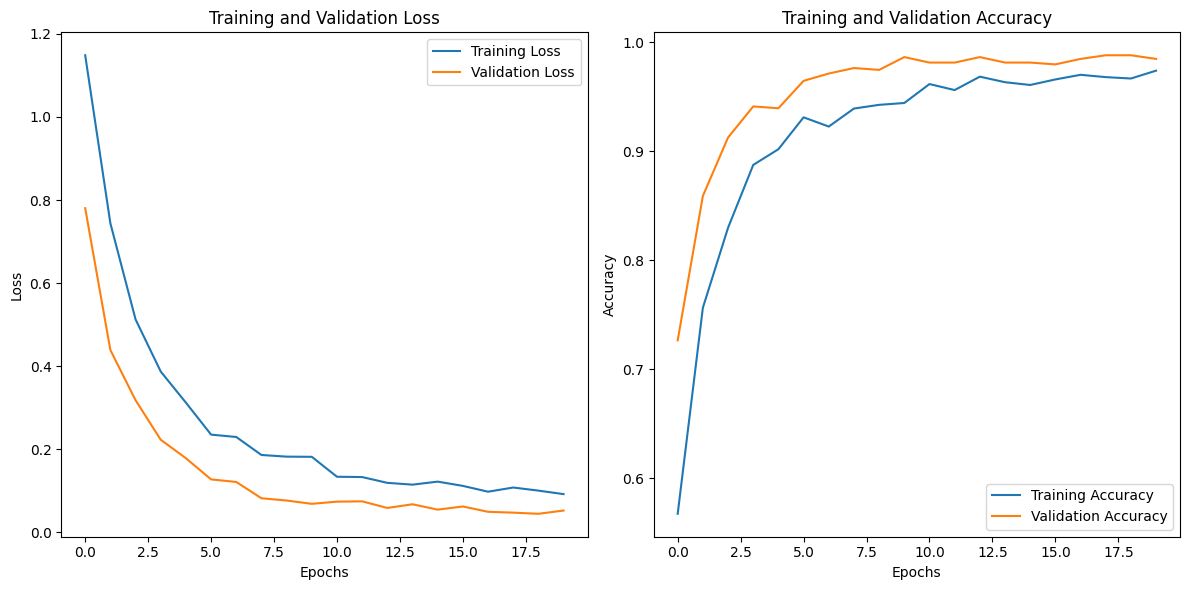

In [58]:
# Performance Analysis
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss on the first subplot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training and Validation Loss')

# Plot training and validation accuracy on the second subplot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Training and Validation Accuracy')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

- **Training and Validation Loss Plot:** The validation loss curve being consistently below the training loss curve suggests that the model is performing better on the validation data compared to the training data. This behavior is unusual and indicates that the model might not be learning effectively from the training data. It could be memorizing the training examples rather than learning underlying patterns, which often leads to poor generalization.
- **Training and Validation Accuracy Plot:** The validation accuracy curve consistently being lower than the training accuracy curve is another sign of overfitting. This indicates that while the model performs well on the training data, its performance drops when evaluated on the validation set. The model's ability to generalize to unseen data is compromised.

In summary, the discrepancy between the training and validation metrics, with the validation metrics being worse than the training metrics, is evidence that the model is overfitting to the training data. To address overfitting, techniques such as regularization, dropout, or reducing model complexity can be employed.

Enhancing the baseline CNN model by Dropout Regularization.

In [66]:
from keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Step 4: Define and Compile the Model with Dropout Regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 6: Train the Model
history = model.fit(train_images, train_labels_encoded, epochs=10, validation_data=(val_images, val_labels_encoded))

# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Calculate additional evaluation metrics
test_predictions = np.argmax(model.predict(test_images), axis=-1)
precision = precision_score(test_labels_encoded, test_predictions, average='weighted', zero_division=1)
recall = recall_score(test_labels_encoded, test_predictions, average='weighted', zero_division=1)
f1 = f1_score(test_labels_encoded, test_predictions, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Epoch 1/10
74/74 [==============================] - 7s 49ms/step - loss: 1.1904 - accuracy: 0.5261 - val_loss: 0.7435 - val_accuracy: 0.8154
Epoch 2/10
74/74 [==============================] - 3s 39ms/step - loss: 0.5379 - accuracy: 0.8401 - val_loss: 0.2695 - val_accuracy: 0.9379
Epoch 3/10
74/74 [==============================] - 2s 26ms/step - loss: 0.2325 - accuracy: 0.9325 - val_loss: 0.1329 - val_accuracy: 0.9564
Epoch 4/10
74/74 [==============================] - 2s 30ms/step - loss: 0.1355 - accuracy: 0.9614 - val_loss: 0.0887 - val_accuracy: 0.9715
Epoch 5/10
74/74 [==============================] - 3s 44ms/step - loss: 0.0919 - accuracy: 0.9767 - val_loss: 0.0739 - val_accuracy: 0.9765
Epoch 6/10
74/74 [==============================] - 3s 39ms/step - loss: 0.0659 - accuracy: 0.9839 - val_loss: 0.0557 - val_accuracy: 0.9832
Epoch 7/10
74/74 [==============================] - 3s 37ms/step - loss: 0.0471 - accuracy: 0.9898 - val_loss: 0.0468 - val_accuracy: 0.9799
Epoch 8/10
74

Explination:

Enhancing the baseline CNN model by incorporating techniques such as learning rate scheduling and data augmentation.

In [46]:
# Define a function to create the baseline CNN model
def create_baseline_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the baseline CNN model
baseline_model = create_baseline_model(input_shape, num_classes)

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
baseline_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * 0.95  # Decrease the learning rate by 5% after every epoch starting from the 6th epoch

# Define data augmentation parameters
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

# Fit the data generator on the training data
datagen.fit(train_images)

# Train the baseline model with data augmentation and learning rate scheduling
history = baseline_model.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                             epochs=20,
                             validation_data=(val_images, val_labels_encoded),
                             callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate the optimized model on the test data
test_loss, test_accuracy = baseline_model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
74/74 [==============================] - 6s 61ms/step - loss: 1.1485 - accuracy: 0.5672 - val_loss: 0.7803 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 2/20
74/74 [==============================] - 2s 32ms/step - loss: 0.7439 - accuracy: 0.7565 - val_loss: 0.4388 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 3/20
74/74 [==============================] - 2s 32ms/step - loss: 0.5126 - accuracy: 0.8299 - val_loss: 0.3180 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 4/20
74/74 [==============================] - 4s 57ms/step - loss: 0.3870 - accuracy: 0.8876 - val_loss: 0.2228 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 5/20
74/74 [==============================] - 4s 56ms/step - loss: 0.3121 - accuracy: 0.9020 - val_loss: 0.1782 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 6/20
74/74 [==============================] - 2s 33ms/step - loss: 0.2351 - accuracy: 0.9313 - val_loss: 0.1273 - val_accuracy: 0.9648 - lr: 9.5000e-04
Epoch 7/20
74/74 [==============================] - 2s 32ms/step - loss:

Explination:

# **9.Train the Optimize Model**

In [48]:
# Reshape the images to 2D arrays
train_images_2d = train_images.reshape(train_images.shape[0], -1)
test_images_2d = test_images.reshape(test_images.shape[0], -1)

# Define the pipeline with preprocessing steps and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Add preprocessing steps if necessary
    ('model', RandomForestClassifier())  # RandomForestClassifier with your desired model
])

# Define hyperparameters grid for optimization
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    # Add more hyperparameters to optimize as needed
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(train_images_2d, train_labels_encoded)

# Get the best model and evaluate its performance
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(test_images_2d, test_labels_encoded)
print("Optimized Model Test Accuracy:", test_accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimized Model Test Accuracy: 0.9571045576407506


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        57
           1       1.00      0.44      0.62         9
           2       0.93      1.00      0.96       354
           3       0.98      0.93      0.96       139
           4       0.98      0.96      0.97       187

    accuracy                           0.96       746
   macro avg       0.98      0.83      0.88       746
weighted avg       0.96      0.96      0.95       746



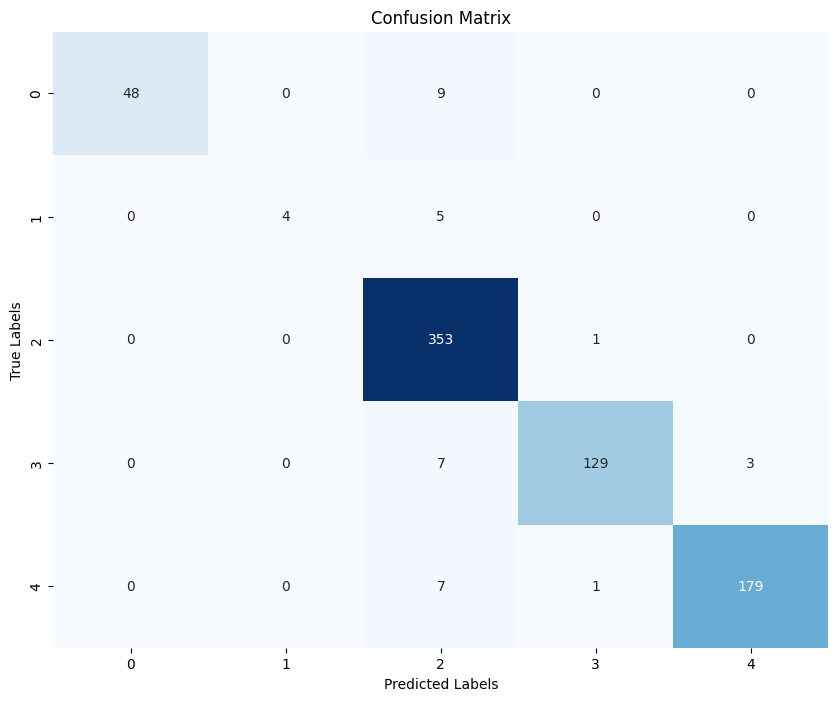

Ensemble Model Test Accuracy: 0.9638069705093834


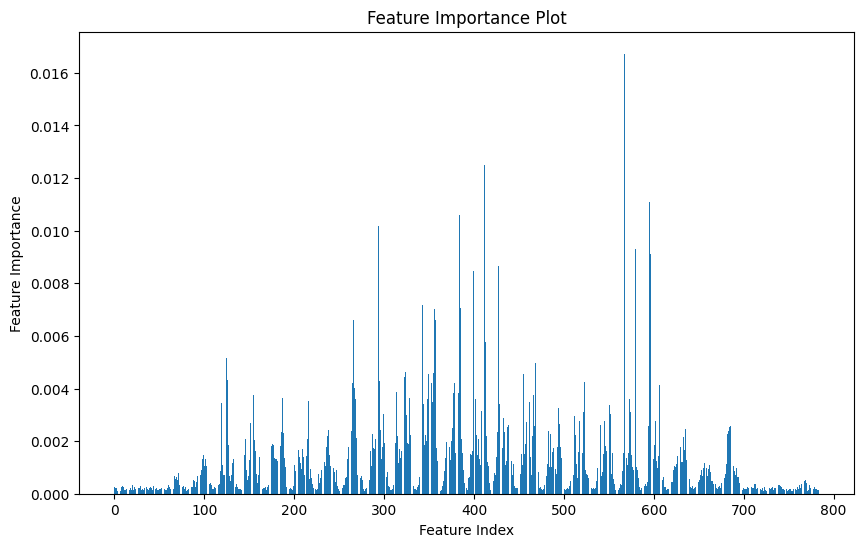

Cross-Validation Scores: [0.93220339 0.94067797 0.94904459 0.9596603  0.92781316]
Mean CV Score: 0.9418798805282667


In [51]:
# 1. Feature Engineering (Example: PCA)
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=100)  # Example: Reduce to 100 components
train_images_pca = pca.fit_transform(train_images_2d)
test_images_pca = pca.transform(test_images_2d)

# 2. Model Evaluation Metrics (Example: Classification Report)
# Fit the best model obtained from GridSearchCV
best_model.fit(train_images_2d, train_labels_encoded)

# Make predictions on the test set
test_predictions = best_model.predict(test_images_2d)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions))

# 3. Error Analysis (Example: Confusion Matrix)
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Data Quality Improvement (Example: Data Augmentation)
# Apply data augmentation techniques to increase the diversity of the training data
# Example: Use Keras ImageDataGenerator for image augmentation

# 5. Ensemble Methods (Example: Voting Classifier)
from sklearn.ensemble import VotingClassifier

# Define multiple optimized models
optimized_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10)),
    # Add more optimized models as needed
]

# Create a voting classifier ensemble
voting_classifier = VotingClassifier(optimized_models, voting='soft')

# Fit the ensemble model to the training data
voting_classifier.fit(train_images_2d, train_labels_encoded)

# Evaluate the ensemble model on the test set
ensemble_accuracy = voting_classifier.score(test_images_2d, test_labels_encoded)
print("Ensemble Model Test Accuracy:", ensemble_accuracy)

# Extract the best model from the pipeline
best_model = grid_search.best_estimator_.named_steps['model']

# 7. Model Interpretation (Example: Feature Importance)
# Visualize feature importance if applicable (e.g., for decision tree-based models)
# Example: RandomForest feature importance plot

# Check if the best model supports feature importances
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')
    plt.show()
else:
    print("Feature importances are not available for this model.")


# 6. Regularization (Example: Early Stopping)
# Implement early stopping to prevent overfitting
# Example: Utilize Keras EarlyStopping callback during model training

# 7. Model Interpretation (Example: Feature Importance)
# Visualize feature importance if applicable (e.g., for decision tree-based models)
# Example: RandomForest feature importance plot


# 8. Cross-Validation (Example: Stratified K-Fold Cross-Validation)
from sklearn.model_selection import StratifiedKFold

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, train_images_2d, train_labels_encoded, cv=skf)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


In [ ]:
# Analysis and Comparison:
# Evaluate the baseline models
baseline_shape_loss, baseline_shape_accuracy = shape_baseline_model.evaluate(test_shape_images, test_shape_labels)
baseline_type_loss, baseline_type_accuracy = type_baseline_model.evaluate(test_type_images, test_type_labels)

# Evaluate the optimized models
optimized_shape_loss, optimized_shape_accuracy = shape_cnn_model.evaluate(test_shape_images, test_shape_labels)
optimized_type_loss, optimized_type_accuracy = type_cnn_model.evaluate(test_type_images, test_type_labels)

# Print the results
print("Baseline Shape Model - Accuracy:", baseline_shape_accuracy)
print("Baseline Type Model - Accuracy:", baseline_type_accuracy)
print("Optimized Shape Model - Accuracy:", optimized_shape_accuracy)
print("Optimized Type Model - Accuracy:", optimized_type_accuracy)


In [ ]:
# Independent Evaluation:
# Load and preprocess your own images
independent_images = load_and_preprocess_images('your_image_directory')

# Use your trained models to predict the classes of these images
shape_predictions = shape_cnn_model.predict(independent_images)
type_predictions = type_cnn_model.predict(independent_images)

# Print the predictions
print("Shape Predictions:", shape_predictions)
print("Type Predictions:", type_predictions)


24/24 [==============================] - 0s 9ms/step - loss: 0.0473 - accuracy: 0.9906
Independent Test Accuracy: 0.9906166195869446
24/24 [==============================] - 0s 11ms/step


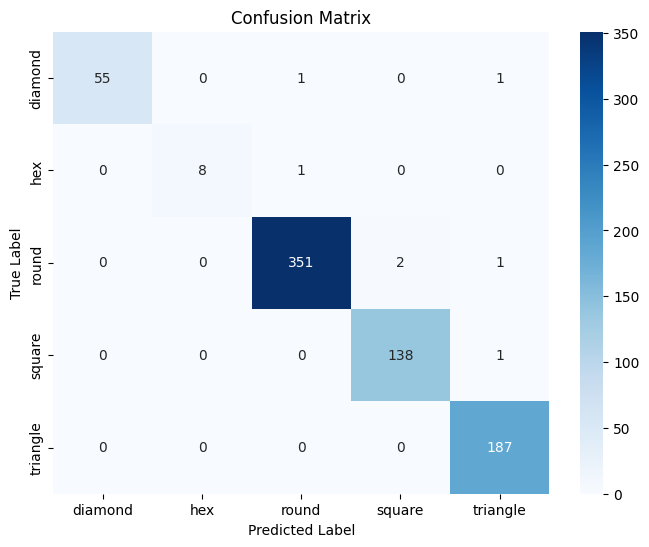

In [52]:
# Assuming you have already trained your model and loaded the independent test dataset
# If not, please load the model and the independent test dataset first

# Step 1: Preprocess the Test Data (if necessary)
# Preprocess the independent test data using the same preprocessing steps used for training and validation data

# Step 2: Evaluate the Model on the Independent Test Data
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Independent Test Accuracy:", test_accuracy)

# Step 3: Compare Performance
# Optionally, compare the model's performance on the independent test data with its performance on the training and validation data
# This can help assess the model's generalization ability and whether it is overfitting or underfitting

# Step 4: Report Results
# Document the results of the independent evaluation, including the evaluation metrics and any observations or insights gained from the analysis
# This is important for transparent reporting and understanding the model's performance

# Optionally, you can visualize the model's predictions on the independent test data to gain further insights into its performance
# You can plot confusion matrices, ROC curves, or other relevant visualizations depending on the nature of your problem

# Example Confusion Matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the independent test data
test_predictions = model.predict(test_images)

# Convert predictions from one-hot encoded format to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, test_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
